## MNIST Dataset
This dataset contains 28x28 grayscale images of digits from 0 to 9. In the train csv file, there are 42000 examples/images.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import Path

path_d = Path("../input/")
path_d.ls()

[PosixPath('../input/sample_submission.csv'),
 PosixPath('../input/train.csv'),
 PosixPath('../input/test.csv')]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_mnist = pd.read_csv(path_d/"train.csv")
label = np.array(df_mnist["label"])
imgs = np.array(df_mnist.drop(['label'],axis=1))
df_mnist.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This function allows us to print out shapes of arrays

In [4]:
def shapes(*x):
    for idx, item in enumerate(x): print(f"arg_{idx}: {item.shape}")

In [5]:
shapes(imgs, label)

arg_0: (42000, 784)
arg_1: (42000,)


Visualize the images in MNIST

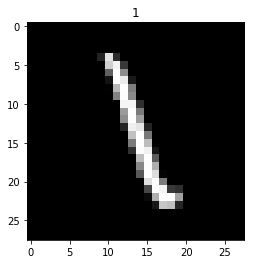

In [6]:
from IPython.display import clear_output
import time

dim = int(imgs.shape[1]**0.5)
for i in np.random.permutation(len(imgs))[:10]:
    plt.imshow(imgs[i].reshape(dim,dim)/255,'gray')
    plt.title(label[i])
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

This is just to clear RAM so that the kernel does not crash

In [7]:
import gc
del df_mnist, label, imgs
gc.collect()

21644

This refactor some code to get the MNIST dataset, so that next time, we can call getMNIST() to get the dataset

In [8]:
def scale(x): return x/255
def split_vals(x,y,n): idxs = np.random.permutation(len(x)); return x[idxs[:n]], x[idxs[n:]], y[idxs[:n]], y[idxs[n:]]

def loadMNIST(path_d):
    df_mnist = pd.read_csv(path_d/"train.csv")
    label = np.array(df_mnist["label"])
    imgs = np.array(df_mnist.drop(['label'],axis=1))
    return imgs, label

def getMNIST():
    imgs, label = loadMNIST(Path("../input/"))
    split_amt= round(imgs.shape[0] * 0.90)
    x_train, x_test, y_train, y_test = split_vals(scale(imgs), label, split_amt)
    return x_train, x_test, y_train, y_test 

## Single Layer Perceptron

![SLP Model](https://www.tutorialspoint.com/tensorflow/images/schematic_representation.jpg)

In [9]:
x_train, x_test, y_train, y_test = getMNIST()
shapes(x_train, x_test, y_train, y_test)

arg_0: (37800, 784)
arg_1: (4200, 784)
arg_2: (37800,)
arg_3: (4200,)


In [10]:
import tensorflow as tf
from tensorflow import keras

slp_model = keras.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=([784])),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

slp_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Classification Loss Functions

![](https://camo.githubusercontent.com/7abce96d3972c027b394d33b63a2493112147c33/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313630302f312a674e755037504e367343343276415957766f414d4d412e706e67)

* categorical_crossentropy -> classification with one-hot encoded labels (ie. [0,0,1])
* sparse_categorical_crossentropy -> classification with discrete labels (ie. [2])

In [11]:
slp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [12]:
slp_model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              epochs=5)

Train on 37800 samples, validate on 4200 samples
Epoch 1/5
37800/37800 [==============================] - 3s 78us/sample - loss: 0.2388 - acc: 0.9301 - val_loss: 0.1440 - val_acc: 0.9529
Epoch 2/5
37800/37800 [==============================] - 2s 64us/sample - loss: 0.0974 - acc: 0.9707 - val_loss: 0.1036 - val_acc: 0.9671
Epoch 3/5
37800/37800 [==============================] - 2s 64us/sample - loss: 0.0620 - acc: 0.9804 - val_loss: 0.0867 - val_acc: 0.9748
Epoch 4/5
37800/37800 [==============================] - 2s 64us/sample - loss: 0.0412 - acc: 0.9869 - val_loss: 0.0829 - val_acc: 0.9740
Epoch 5/5
37800/37800 [==============================] - 2s 64us/sample - loss: 0.0281 - acc: 0.9910 - val_loss: 0.1062 - val_acc: 0.9698


### What is softmax?
##### Softmax function turns numbers aka logits into probabilities that sum to one. Softmax function outputs a vector that represents the probability distributions.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQw0ezjyWQtPMQRSlLJHkCB6rk8QJXA68HMw6NDWyiWTFnp_O-Igg)

In [13]:
def softmax(x): return np.exp(x.squeeze())/sum(np.exp(x.squeeze()))

In [14]:
output = np.array([60,50,10,20,40,20,40,50])
softmax(output)

array([9.999092e-01, 4.539581e-05, 1.928575e-22, 4.247969e-18, 2.060966e-09, 4.247969e-18, 2.060966e-09, 4.539581e-05])

Lets define a function to visualize our results

In [15]:
def seeResults(model, x, y):
    dim=28
    plt.figure(figsize=(20,20))
    idxs = np.random.permutation(len(x))
    for i,idx in enumerate(idxs[:25]):
        plt.subplot(5,5,i+1)
        plt.xticks([]), plt.yticks([])
        plt.grid(False)
        plt.imshow(x[idx].reshape(dim,dim),'gray')
        pred = softmax(model.predict(x[idx][None,:])) #Here the model makes a prediction
        plt.xlabel(f"Label:{y[idx]}, Pred:{np.argmax(pred)}")
    plt.show()

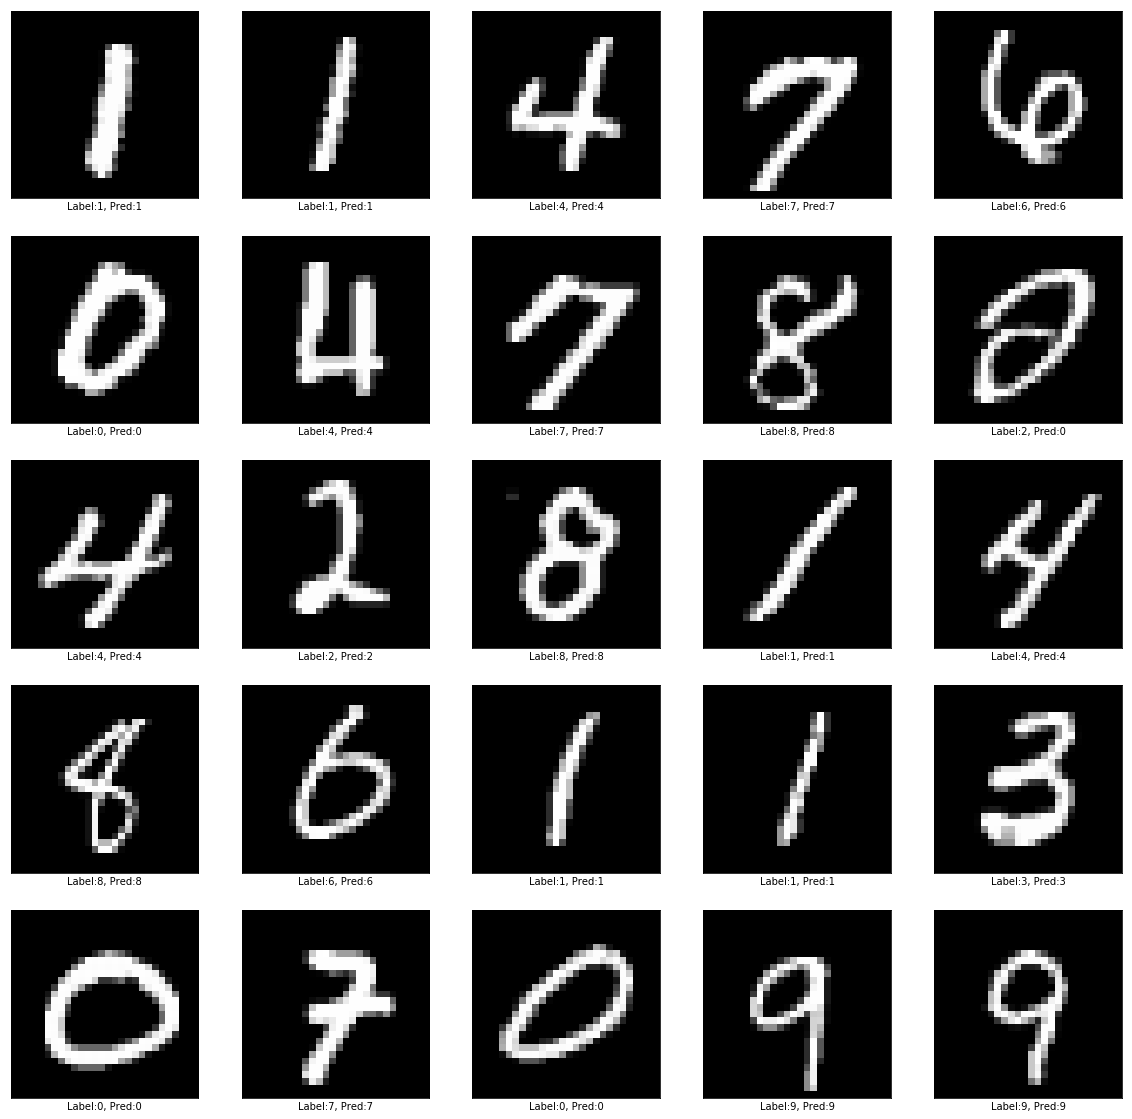

In [16]:
seeResults(slp_model, x_test, y_test)

##### Look inside Keras Dense layer
###### Notice that all it is really doing is matrix multiplication

In [17]:
??keras.layers.Dense.call

## What is matmal() (or dot())

![Matrix multiply](https://miro.medium.com/max/1340/0*TlmHHTp4Lm04vz03.gif)

In [18]:
def matmul1(a,b):
    ar,ac = a.shape
    br,bc = b.shape 
    assert ac==br
    c = np.zeros(shape=(ar, bc))
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

def matmul2(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = np.zeros(shape=(ar, bc))
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

def matmul3(a,b): return np.einsum('ik,kj->ij', a, b)

![](https://miro.medium.com/max/638/1*HX11BnJo4rY1IfY8vU86jA.gif)

In [19]:
np.random.seed(0)
a = np.random.randn(128,128)
b = np.random.randn(128,128)

%time x = matmul1(a,b)
%time y = matmul2(a,b)
%time z = matmul3(a,b)
%time t = tf.matmul(a,b)

CPU times: user 1.64 s, sys: 0 ns, total: 1.64 s
Wall time: 1.64 s
CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 67.1 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.06 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.5 ms


Lets compare the results, and see if they are really equal

In [20]:
def compare(x,y): print(np.isclose(x,y).all())
compare(x,y), compare(x,z)

True
True


(None, None)

## Multi-Layer Perceptron

In [21]:
x_train, x_test, y_train, y_test = getMNIST()

In [22]:
mlp_model = keras.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

mlp_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
mlp_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1)

Train on 37800 samples, validate on 4200 samples
37800/37800 [==============================] - 3s 82us/sample - loss: 0.2346 - acc: 0.9276 - val_loss: 0.1664 - val_acc: 0.9500


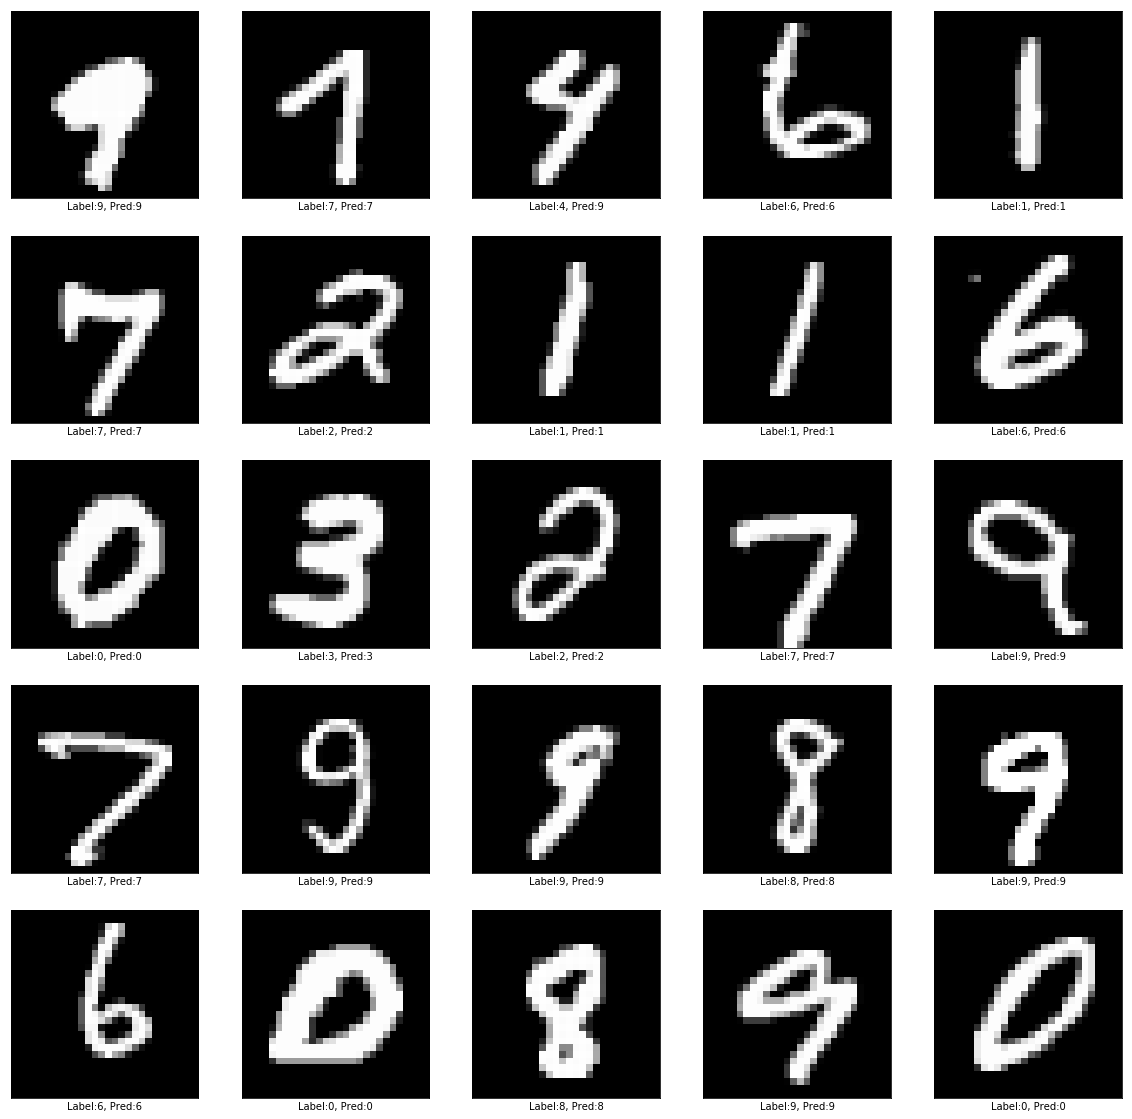

In [24]:
seeResults(mlp_model, x_test, y_test)